In [1]:
import torch  
import torch.nn as nn 
import torchvision as tv
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import cv2


In [2]:
class conv(nn.Module):
    def __init__(self,in_n,out_n,k_size=3,std=1,pad=0):
        super().__init__()
        self.forw=nn.Sequential(
            nn.Conv2d(in_n,out_n,kernel_size=k_size,stride = std,padding=pad),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.forw(x)

class convT(nn.Module):
    def __init__(self,in_n,out_n,k_size=4,std=2,pad=1,outpad=0):
        super().__init__()
        self.forw=nn.Sequential(
            nn.ConvTranspose2d(in_n,out_n,kernel_size=4,stride=2,padding=1,output_padding=outpad),            #[b,16,7,7] ———> [b,16,14,14]
            nn.ReLU(),
        )
    def forward(self, x):
        return self.forw(x)

#先对输入图片进行降采样
#将b*3*960*960转为b*128*60*60
class downsample(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
                conv(3,32,3,1,1),
                conv(32,128,pad=1),
                conv(128,256,pad=1),
                conv(256,512,pad=1),
        )
    def forward(self, x):
        return self.forw(x)
#对中间结果上采样，b*128*60*60转为b*3*960*960
class upsample(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
                convT(512,256),
                convT(256,128),
                convT(128,32),
                convT(32,3),
        )
    def forward(self, x):
        return self.forw(x)
        
#对降采样结果进行更高的降维，转为一个b*32*10*10的特征图
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
            nn.Conv2d(128,128,5),# 56*56
            nn.Conv2d(128,64,5),# 52*52
            nn.Conv2d(64,64,5),# 48*48
            conv(64,64,1),#24*24
            nn.Conv2d(64,32,3),# 22*22
            nn.Conv2d(32,32,3),# 20*20
        )
    def forward(self, x):
        return self.forw(x)
#将b*32*10*10的特征图恢复为b*128*60*60
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.forw=nn.Sequential(
            nn.ConvTranspose2d(32,32,3),# 22*22
            nn.ConvTranspose2d(32,64,3),# 24*24
            convT(64,64),#48*48
            nn.ConvTranspose2d(64,64,5),# 52*52
            nn.ConvTranspose2d(64,128,5),# 56*56
            nn.ConvTranspose2d(128,128,5),# 60*60
        )
    def forward(self, x):
        return self.forw(x)

In [3]:
#全连接编码层，预测mu和log_var
class linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode=nn.Sequential(
            nn.Linear(40*40*32,1024),
            nn.ReLU(),
            # nn.Linear(1024,256),
            # nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
        )
        self.decode=nn.Sequential(
            nn.Linear(128,1024),
            nn.ReLU(),
            # nn.Linear(256,1024),
            # nn.ReLU(),
            nn.Linear(1024,40*40*32),
            nn.ReLU(),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # 计算标准差
        eps = torch.randn_like(std)  # 从标准正态分布中采样噪声
        z = mu + eps * std  # 重参数化技巧
        return z
        
    def forward(self,x):
        encoded = x#self.encode(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)  # 将输出分割为均值和方差
        z = self.reparameterize(mu, logvar)  # 重参数化
        decoded = z#self.decode(z)
        return decoded, mu, logvar
        
class mysample(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = downsample()
        #self.line = linear()
        self.up = upsample()
    def forward(self, x):
        out = self.down(x)
#         lout = out.view(out.shape[0],-1)
#         lout,mu,logvar = self.line(lout)
#         out = lout.view((1,16,40,40))
        out = self.up(out)
        return out

In [4]:
shape = (960,960)

transform = transforms.Compose(
    [transforms.Resize(shape),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ]
)

train_set = dataset.ImageFolder('Baidu',transform=transform)
test_set = dataset.ImageFolder('验证',transform=transform)
train_ld = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=3,
                                           shuffle=True
                                                )
print(len(train_ld))
device=torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
print(device)

177
cuda


In [5]:
def grayloss(a,b):
    img1 = 0.33*a[:,0,:,:]+0.33*a[:,1,:,:]+0.34*a[:,2,:,:]
    img2 = 0.33*b[:,0,:,:]+0.33*b[:,1,:,:]+0.34*b[:,2,:,:]
    loss = torch.abs(img1-img2).mean()
    return loss

In [8]:
pre = True
train = True
sample = mysample().to(device)

style_img = cv2.imread("style/style.png")
style_img = transforms.Resize((960,960))(transforms.ToTensor()(style_img)).to(device)
print(style_img.shape)

if pre:
    sample.load_state_dict(torch.load('./checkpoint/sample.pt'))
loss_fn=nn.MSELoss(reduction='mean')
opt=torch.optim.Adam(sample.parameters(),lr=1e-3)
if train:
    for epoch in range(5):
        for i,(y,_) in enumerate(train_ld):
            y = y.to(device)
            #print(y)
            y_pre=sample(y)#,mu,log_var
            loss=1e1*loss_fn(y_pre,style_img)+1e1*grayloss(y_pre,y)
            # kl_loss=-0.05*torch.mean((log_var+1-mu**2-torch.exp(log_var)))
            # loss=loss+kl_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i%50 == 0:
                print("epoch/i: ",epoch,i,"loss:",loss.item())

D:\zdy\anaconda3\envs\ame\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
D:\zdy\anaconda3\envs\ame\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3, 960, 960])) that is different to the input size (torch.Size([3, 3, 960, 960])). This will likely lead to incorrect results due to broadcasting. Please ensure 

torch.Size([3, 960, 960])
epoch/i:  0 0 loss: 3.554889678955078
epoch/i:  0 50 loss: 4.3445844650268555
epoch/i:  0 100 loss: 3.572204828262329


D:\zdy\anaconda3\envs\ame\lib\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch/i:  0 150 loss: 2.965057373046875
epoch/i:  1 0 loss: 3.717881679534912
epoch/i:  1 50 loss: 4.515758037567139
epoch/i:  1 100 loss: 5.380841255187988
epoch/i:  1 150 loss: 3.1357312202453613
epoch/i:  2 0 loss: 2.305138111114502
epoch/i:  2 50 loss: 3.0999584197998047
epoch/i:  2 100 loss: 4.441998481750488
epoch/i:  2 150 loss: 6.927642822265625
epoch/i:  3 0 loss: 3.0883004665374756
epoch/i:  3 50 loss: 5.365066051483154
epoch/i:  3 100 loss: 5.86572265625
epoch/i:  3 150 loss: 5.2191243171691895
epoch/i:  4 0 loss: 2.9761152267456055
epoch/i:  4 50 loss: 7.068514823913574
epoch/i:  4 100 loss: 2.7712583541870117
epoch/i:  4 150 loss: 4.134714126586914


In [10]:
# torch.save(sample.state_dict(),'./checkpoint/sample.pt')
torch.save(sample.state_dict(),'./checkpoint/sample.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

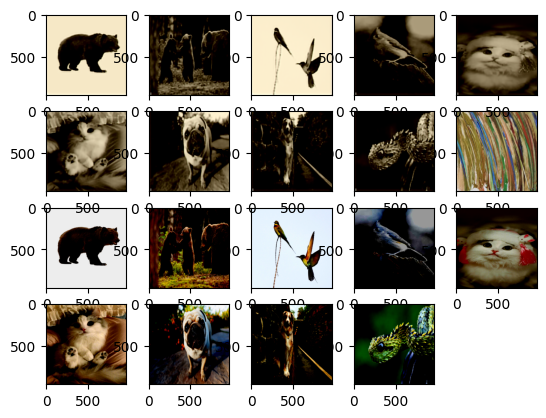

In [9]:
import matplotlib.pyplot as plt
import numpy as np
with torch.no_grad():
    for i,(y,_) in enumerate(test_set):
            y = y.to(device).unsqueeze(0)
            #print(y.shape)
            y_pre=sample(y)
            # y_pre,_,_=sample(y)
            if i%10 == 0:
                # y_pre = y_pre.view(1,3,shape[0],shape[1])
                # y = y.view(1,3,shape[0],shape[1])
                y_pre = (y_pre.cpu().squeeze().permute(1,2,0).numpy())
                y = (y.cpu().squeeze().permute(1,2,0).numpy())
                # y_pre = (y_pre.cpu().squeeze().numpy())
                # y = (y.cpu().squeeze().numpy())
                #print(y_pre)
                plt.subplot(4,5,10)
                plt.imshow(style_img.cpu().permute(1,2,0).numpy())
                plt.subplot(4,5,i//10+1)
                plt.imshow(y_pre),#cmap='gray'
                plt.subplot(4,5,i//10+11)
                plt.imshow(y)#,cmap='gray'